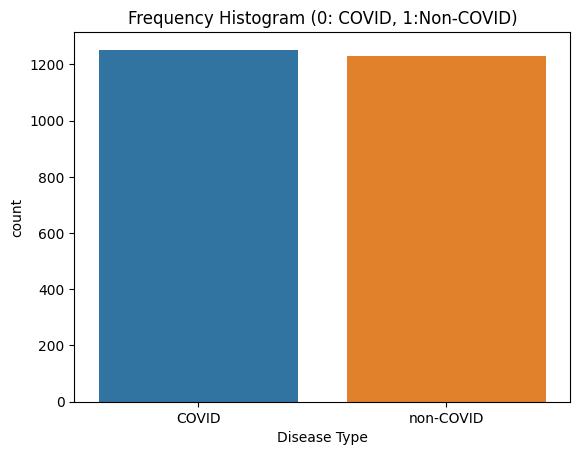

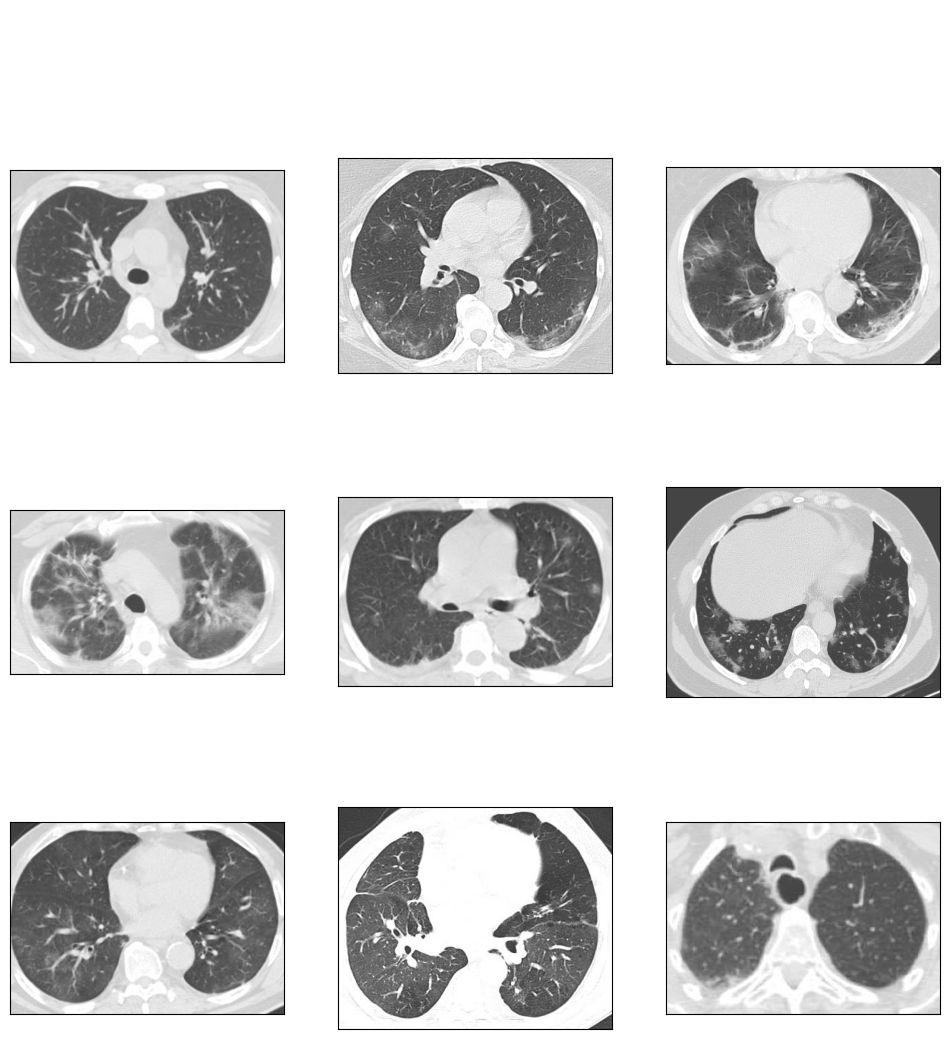

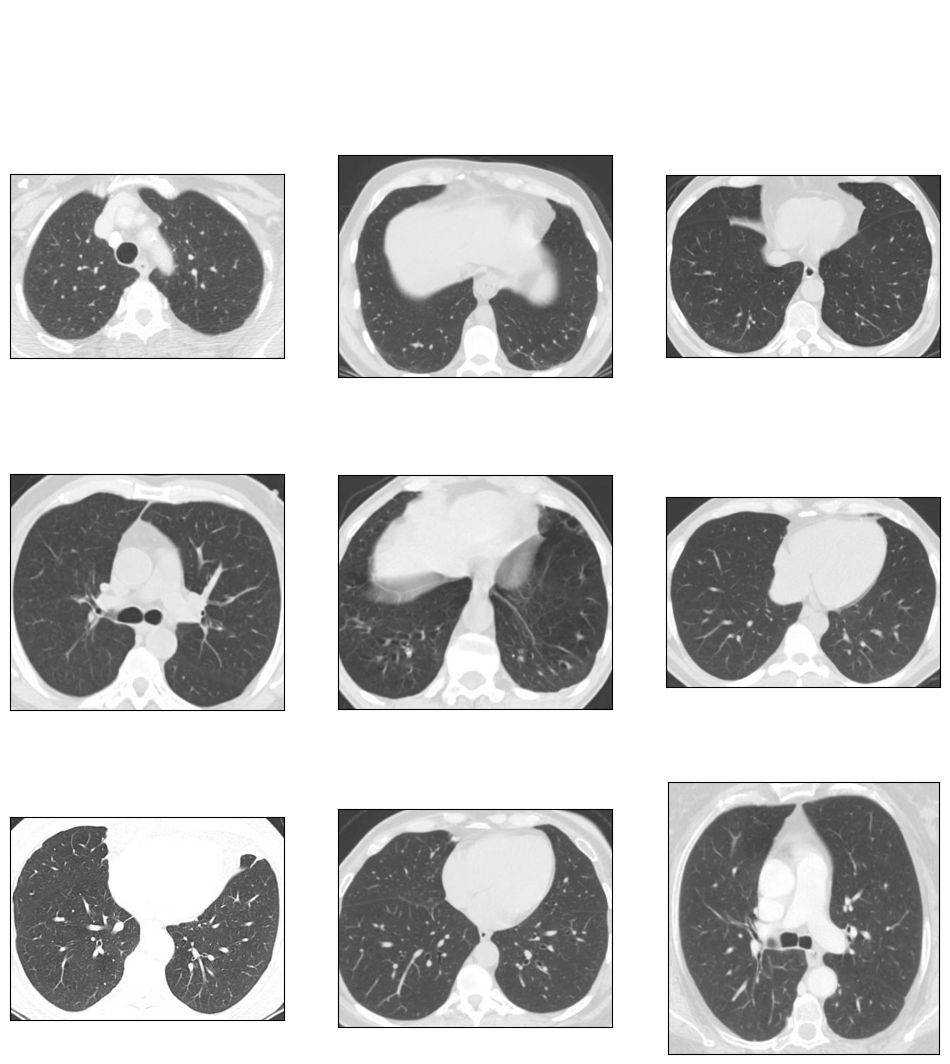

In [2]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

# Set random seed for reproducibility
Seed = 40
np.random.seed(Seed)
tf.random.set_seed(Seed)

# Define disease types
disease_types = ['COVID', 'non-COVID']

# Define data directory
data_dir = '/content/drive/MyDrive/Desertation/CTSCAN'

# Read and preprocess data
train_data = []
for index, sp in enumerate(disease_types):
    for file in os.listdir(os.path.join(data_dir, sp)):
        train_data.append([sp + "/" + file, index, sp])

train = pd.DataFrame(train_data, columns=['File', 'ID', 'Disease Type'])

# Shuffle the data
train = train.sample(frac=1, replace=False, random_state=Seed).reset_index(drop=True)

# Display the distribution of classes
sns.countplot(x="Disease Type", data=train)
plt.title("Frequency Histogram (0: COVID, 1:Non-COVID)")
plt.show()

# Function to plot sample images for each class
def plot_defects(defect_types, rows, cols):
    fig, ax = plt.subplots(rows, cols, figsize=(12, 12))
    defect_files = train['File'][train['Disease Type'] == defect_types].values

    fig.suptitle(defect_types, fontsize=22, color="white")
    for i in range(rows):
        for j in range(cols):
            image_path = os.path.join(data_dir, defect_files[i * cols + j])
            image = cv2.imread(image_path)
            ax[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            ax[i, j].set_xticks([])
            ax[i, j].set_yticks([])
    plt.show()

# Display sample images for each class
plot_defects('COVID', 3, 3)
plot_defects('non-COVID', 3, 3)

# Constants for image processing
IMAGE_SIZE = 224
channels = 3

# OpenCV Function to load colored image
def read_image(filepath):
    return cv2.imread(os.path.join(data_dir, filepath))

# OpenCV Function to resize an image
def resize_image(image, image_size):
    return cv2.resize(image.copy(), image_size, interpolation=cv2.INTER_AREA)

# Prepare the data
X_train = np.zeros((train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 3))

for i, file in enumerate(train['File'].values):
    image = read_image(file)
    if image is not None:
        X_train[i] = resize_image(image, (IMAGE_SIZE, IMAGE_SIZE))

X_train = X_train / 255.0  # Pixel normalization

Y_train = to_categorical(train['ID'].values, num_classes=2)

# Split the data into train and validation sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train,
                                                  Y_train,
                                                  test_size=0.2,
                                                  random_state=Seed)



Epoch 1/25
62/62 [==============================] - ETA: 0s - loss: 0.7605 - accuracy: 0.6492
Epoch 1: val_loss improved from inf to 0.82022, saving model to model.h5
62/62 [==============================] - 23s 323ms/step - loss: 0.7605 - accuracy: 0.6492 - val_loss: 0.8202 - val_accuracy: 0.4366 - lr: 0.0030
Epoch 2/25
62/62 [==============================] - ETA: 0s - loss: 0.5610 - accuracy: 0.7147
Epoch 2: val_loss improved from 0.82022 to 0.80017, saving model to model.h5
62/62 [==============================] - 20s 318ms/step - loss: 0.5610 - accuracy: 0.7147 - val_loss: 0.8002 - val_accuracy: 0.3561 - lr: 0.0030
Epoch 3/25
62/62 [==============================] - ETA: 0s - loss: 0.5051 - accuracy: 0.7621
Epoch 3: val_loss improved from 0.80017 to 0.73807, saving model to model.h5
62/62 [==============================] - 20s 319ms/step - loss: 0.5051 - accuracy: 0.7621 - val_loss: 0.7381 - val_accuracy: 0.5231 - lr: 0.0030
Epoch 4/25
62/62 [==============================] - ETA:

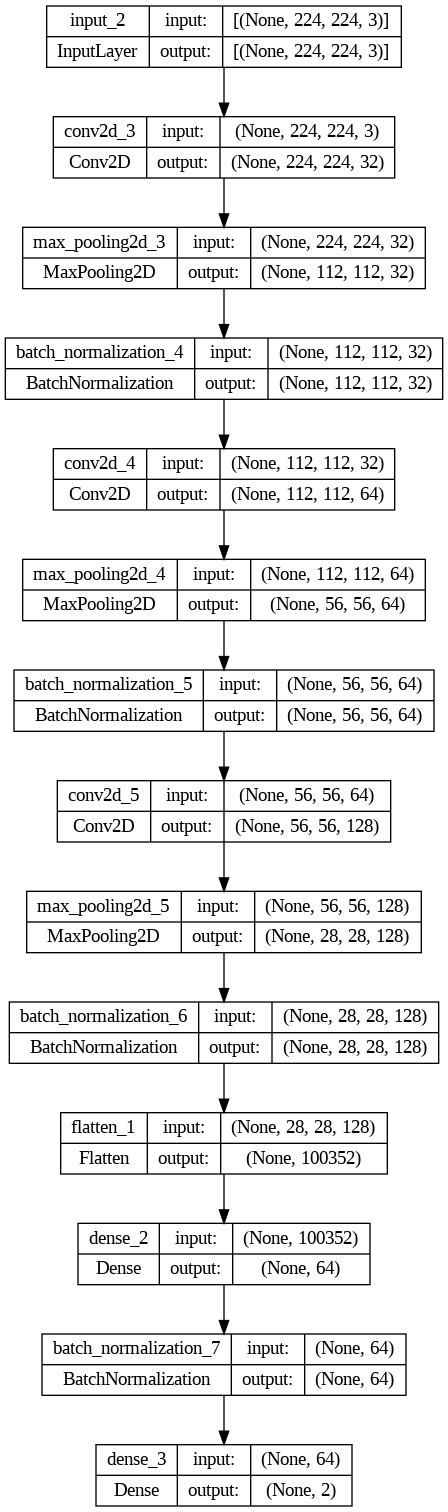

In [8]:
# Build your own custom CNN model
def build_custom_model(image_size, channels):
    inputs = Input(shape=(image_size, image_size, channels))
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = BatchNormalization()(x)

    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)

    outputs = Dense(2, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)

    optimizer = Adam(learning_rate=0.003, beta_1=0.9, beta_2=0.999, epsilon=0.1)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #model.summary()

    return model

# Build your own custom CNN model
model = build_custom_model(IMAGE_SIZE, channels)

# Define the callbacks
annealer = ReduceLROnPlateau(monitor='val_accuracy', factor=0.70, patience=5, verbose=1, min_lr=1e-4)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=360,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

# Fit the model with augmented images
datagen.fit(X_train)
import time
# Evaluate the model
start_time = time.time()

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=32),
    steps_per_epoch=X_train.shape[0] // 32,
    epochs=25,
    verbose=1,
    callbacks=[annealer, checkpoint],
    validation_data=(X_val, Y_val)
)
end_time = time.time()
total_time = end_time - start_time
frame_rate = len(X_val) / total_time
print(f"Frame Rate: {frame_rate:.2f} samples/s")

# Save the model architecture as a plot
tf.keras.utils.plot_model(model, to_file='convnet.png', show_shapes=True, show_layer_names=True)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


16/16 [==============================] - 0s 8ms/step
Accuracy: 0.8651911468812877
Precision: 0.8092105263157895
Recall: 0.9647058823529412
F1 Score: 0.8801431127012522
ROC AUC Score: 0.9528115378382758
Confusion Matrix:
 [[184  58]
 [  9 246]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.76      0.85       242
           1       0.81      0.96      0.88       255

    accuracy                           0.87       497
   macro avg       0.88      0.86      0.86       497
weighted avg       0.88      0.87      0.86       497

Validation Loss: 0.3225477337837219


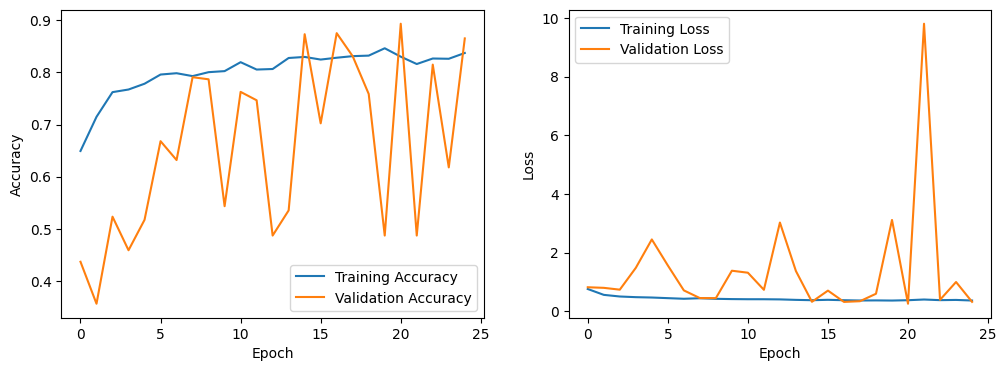

True Positive: 246
False Negative: 9
True Negative: 184
False Positive: 58
True Positive Rate: 0.9647058823529412
True Negative Rate: 0.7603305785123967



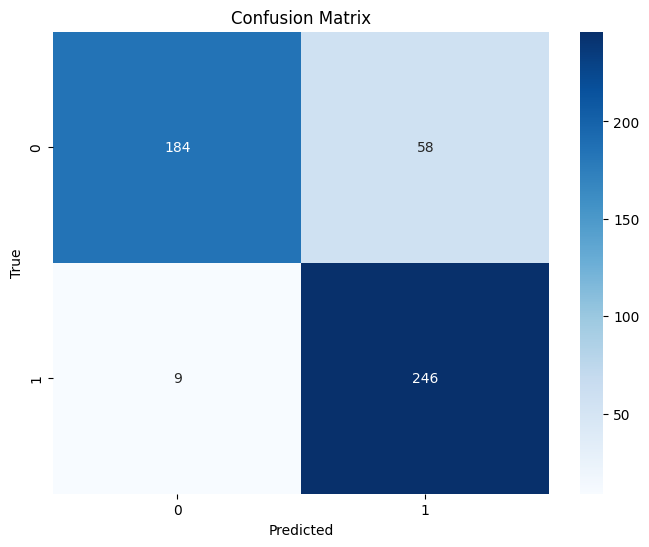

In [9]:


from sklearn.metrics import confusion_matrix


from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, mean_squared_error, r2_score
  #Calculate evaluation metrics
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

accuracy = accuracy_score(np.argmax(Y_val, axis=1), y_pred_classes)
precision = precision_score(np.argmax(Y_val, axis=1), y_pred_classes)
recall = recall_score(np.argmax(Y_val, axis=1), y_pred_classes)
f1 = f1_score(np.argmax(Y_val, axis=1), y_pred_classes)
roc_auc = roc_auc_score(Y_val, y_pred)
cm = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)
classification_rep = classification_report(np.argmax(Y_val, axis=1), y_pred_classes)
loss_val = model.evaluate(X_val, Y_val, verbose=0)[0]

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC Score:", roc_auc)
print("Confusion Matrix:\n", cm)
print("Classification Report:\n", classification_rep)
print("Validation Loss:", loss_val)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

TP = cm[1][1]
print(f"True Positive: {TP}")

FN = cm[1][0]
print(f"False Negative: {FN}")

TN = cm[0][0]
print(f"True Negative: {TN}")

FP = cm[0][1]
print(f"False Positive: {FP}")

# Sensitivity, recall, or true positive rate
print(f"True Positive Rate: {TP / (TP + FN)}")

# Specificity or true negative rate
print(f"True Negative Rate: {TN / (TN + FP)}\n")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import precision_recall_curve, auc

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(Y_val, axis=1), y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


